## Assignment 3 - Identifying spam

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('data.csv')
data.sample(5)

,Class,Message
661,ham,"Under the sea, there lays a rock. In the rock,..."
2336,ham,Which is weird because I know I had it at one ...
910,spam,"January Male Sale! Hot Gay chat now cheaper, c..."
3515,ham,I always chat with you. In fact i need money c...
2272,ham,Life spend with someone for a lifetime may be ...


In [3]:
data.shape

(5574, 2)

### Data exploration

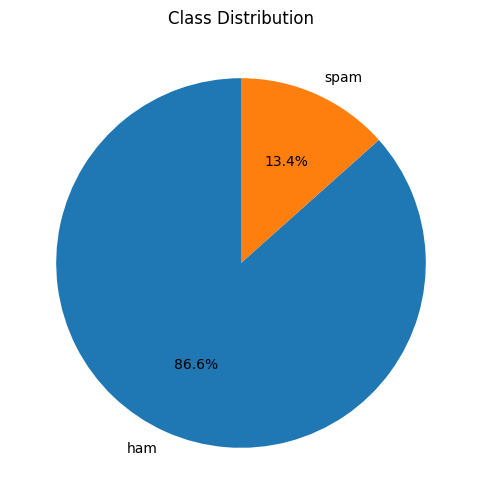

In [4]:
plt.figure(figsize=(10, 6))
plt.pie(data['Class'].value_counts(), labels=data['Class'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

We can see that there is a lot more `ham` messages than `spam` messages. This could prove tough for our model as it could become biased and miss some of the spams. Therefore we need to remember to adjust the data so that the ratio is more balanced.

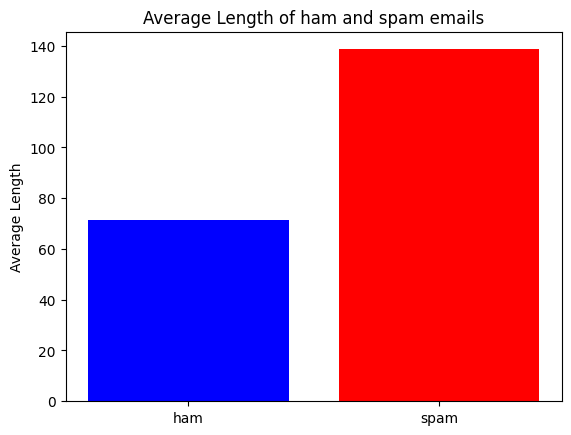

In [5]:
data['Length'] = data['Message'].apply(len)

avg_length_spam = data[data['Class'] == 'spam']['Length'].mean()
avg_length_ham = data[data['Class'] == 'ham']['Length'].mean()

plt.bar(["ham", "spam"], [avg_length_ham, avg_length_spam], color=['blue', 'red'])
plt.title('Average Length of ham and spam emails')
plt.ylabel('Average Length')
plt.show()

### Data pre-processing

From the plot above, we can see that `spam` emails are much longer on average. We created a new column for our data called `Length` as we think that it will help our model with identifying the classes better (more info = better results).

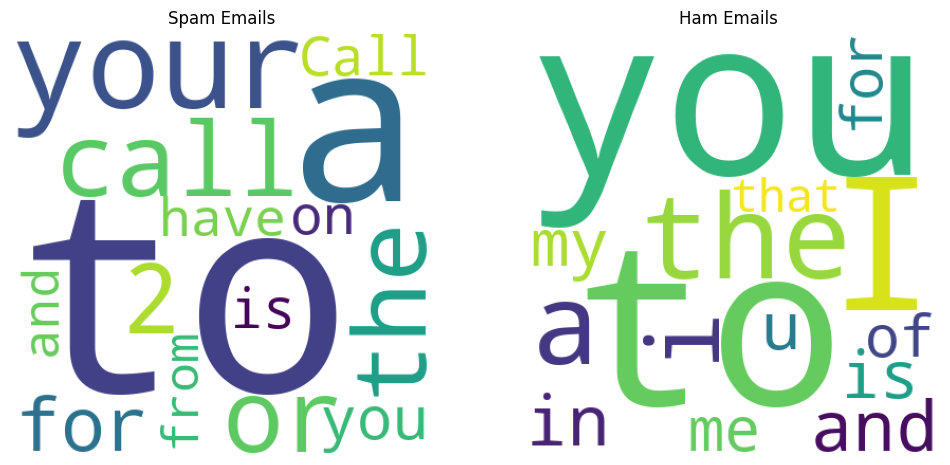

In [6]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['Message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['Message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()


In the plots above, we can see that there are multiple words that are frequent in both, spam and ham emails. This could be very confusing for our model so to make it better we will remove those words from all the messages. 

The wordswe will remove (we basically took the ones that look similarly important in both plots): 
- to
- the
- and
- a
- is

In [7]:
stopwords = ['to', 'the', 'and', 'a', 'is']

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

data['transformed_message'] = data['Message'].apply(remove_stopwords)

In [8]:
data.sample(5)

,Class,Message,Length,transformed_message
3128,ham,Thats cool. i liked your photos. You are very ...,51,Thats cool. i liked your photos. You are very ...
2882,ham,Printer is cool. I mean groovy. Wine is groovying,49,Printer cool. I mean groovy. Wine groovying
2926,ham,Are you coming to day for class.,32,Are you coming day for class.
2343,spam,Double your mins & txts on Orange or 1/2 price...,160,Double your mins & txts on Orange or 1/2 price...
1846,ham,Hi. || Do u want | to join me with sts later? ...,93,Hi. || Do u want | join me with sts later? || ...


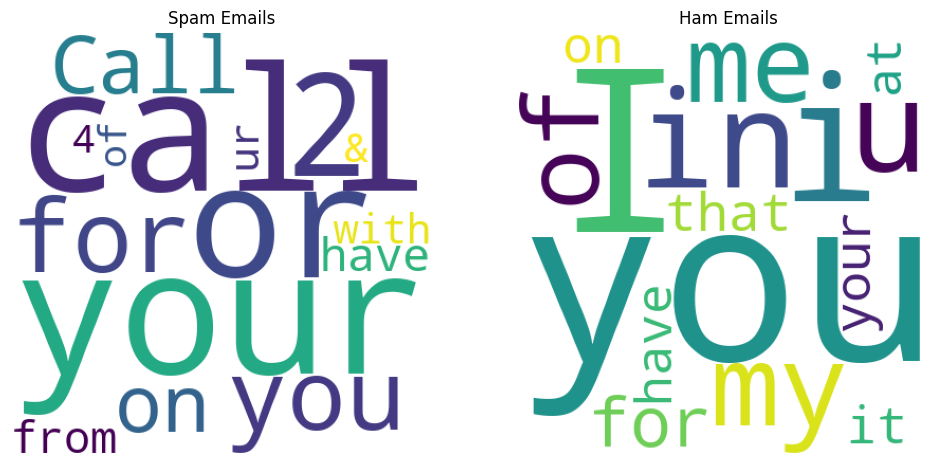

In [9]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['transformed_message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['transformed_message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()

### Model implementation

Lets try to implement the following structure:

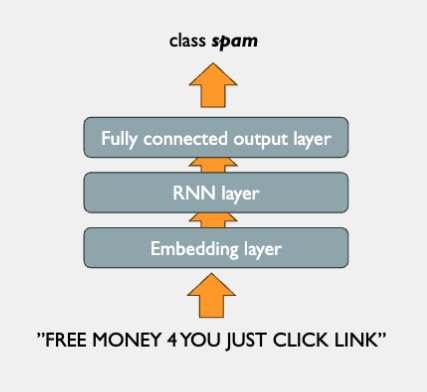

We will implement 2 different versions of the RNN model, one with character embedding and the other with word embedding

#### Character embedding

We want to use embeddings instead of one-hot encoding to camputure relation between words.

In [24]:
data["Class"] = data["Class"].map({"ham": 0, "spam": 1})  # Convert class to binary
X = data["transformed_message"].values
y = data["Class"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
text_vec_layer = tf.keras.layers.TextVectorization(split = "character", standardize = "lower")
text_vec_layer.adapt(X_train)

text_vec_layer.get_vocabulary()[:10]
n_tokens = text_vec_layer.vocabulary_size()

X_train_vectorized = np.asarray(text_vec_layer(X_train))

In [37]:
from gc import callbacks


embed = tf.keras.layers.Embedding(input_dim=n_tokens + 1, output_dim=64, mask_zero=True) #+1 because we use mask_zero=True
embed(X_train_vectorized)

rnn = keras.Sequential([
    layers.LSTM(128),
])

model = tf.keras.Sequential([
    embed,
    rnn,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision', 'recall', 'accuracy'])

lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
es = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model.fit(X_train_vectorized, y_train, validation_split=0.2, epochs=5, batch_size=64, callbacks=[lr, es])

Epoch 1/5


/Users/dksimmay/Documents/VIA/Semester7/MAL2/Assignment3/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'sequential_3' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


23/56 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0000e+00 - loss: nan - precision: 1.0000 - recall: 0.1471

KeyboardInterrupt: 